In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
import database
reload(database)
db = database.thomas_18_db

In [130]:
# figdir_root='/mnt/home/szheng/ceph/place_variability/fig/explore_imaging/'
figdir='/mnt/home/szheng/ceph/place_variability/fig/fig_within_across_imaging'
# figdir = os.path.join(figdir_root,'pv_corr')
figdir= misc.get_or_create_subdir(figdir)

/mnt/home/szheng/ceph/place_variability/fig/fig_within_across_imaging made!


In [4]:
sys.path.append('/mnt/home/szheng/projects/place_variability/code/thomas_18_data')

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [5]:
import fr_map_thomas_all_sess as fmtas
reload(fmtas)
import get_thomas_cell_metrics as gtcm
reload(gtcm)
# import unimodal_nmf as unmf

<module 'get_thomas_cell_metrics' from '/mnt/home/szheng/projects/place_variability/code/thomas_18_data/get_thomas_cell_metrics.py'>

In [6]:
%%time
reload(fmtas)
fr_map_all = fmtas.main(force_reload=False,load_only=True,dosave=True,bin_size=0.022,gauss_width=1,save_fn_one='fr_map_mask_True_smallbin.p',save_fn_all='fr_map_mask_True_smallbin.p')
# fr_map_all = fmtas.main(force_reload=False,load_only=False,dosave=False)
fr_map_trial_df_all = fr_map_all['fr_map_trial_df_all']

occu_map = fr_map_all['occu_map_all']

frmap = fr_map_all['fr_map_all']
fr_map_trial_all = fr_map_all['fr_map_trial_all']

/mnt/home/szheng/ceph/ad/thomas_data/180301_DG_CA3_CA1/fr_map_mask_True_smallbin.p exists; loading---
CPU times: user 220 ms, sys: 5.57 s, total: 5.79 s
Wall time: 44.7 s


In [7]:
# reshape fr_map_trial_df_all to make it easier to work with
fr_map_trial_df_all_day =fr_map_trial_df_all.unstack(level=2).swaplevel(0,1,axis=1).sort_index(axis=1) # day in column
fr_map_trial_df_all_per_uid=fr_map_trial_df_all.unstack(level=(2,3)).swaplevel(0,1,axis=1).swaplevel(1,2,axis=1).sort_index(axis=1).dropna(axis=1,how='all')
frmap_all_day = frmap.unstack(level=2).swaplevel(0,1,axis=1).sort_index(level=0,axis=1)

In [8]:
reload(gtcm)
reload(pa)
per_cell_metrics=gtcm.get_variability_metrics(frmap,occu_map,fr_map_trial_df_all)

/mnt/home/szheng/projects/util_code/place_cell_analysis.py:213: PerformanceWarning: indexing past lexsort depth may impact performance.
  frmap_one=frmap.loc[kk].dropna(axis=1)
/mnt/home/szheng/projects/util_code/place_cell_analysis.py:205: RuntimeWarning: invalid value encountered in true_divide
  div = (fr_map_v / fr_mean[:,None])


In [9]:
region,exp = db.iloc[0][['region','exp_ind']]
isnovel =0
reload(gtcm)
fr_map_trial_df_all_day_sub = fr_map_trial_df_all_day.loc[(region,exp,isnovel),:].dropna(axis=1,how='all')
beg_end_corr_diff_df = gtcm.get_end_beg_diff_minus_beg_end_same_all(fr_map_trial_df_all_day_sub,cell_level=0,n_tr = 3,do_bonf=True)




100%|██████████| 574/574 [00:06<00:00, 88.29it/s]


In [13]:
reload(gtcm)
beg_end_corr_diff_df_allsess=gtcm.get_end_beg_diff_minus_beg_end_same_all_sessions(fr_map_trial_df_all_day,cell_level=0,n_tr = 3,day_level=0,test='ranksums',alpha=0.05,do_bonf=True)



100%|██████████| 222/222 [00:03<00:00, 65.41it/s]


In [43]:
beg_end_corr_diff_df_allsess['categories'] = pd.Categorical(zip(beg_end_corr_diff_df_allsess['across_bigger'],beg_end_corr_diff_df_allsess['issig']),ordered=True)



In [201]:
def plot_scatter_line_and_pie(toplot,x,y,hue,dosave=False,region='',isnovel=None,fig=None,axs=None,save_fn_extra=''):
    if axs is None:
        fig,axs=plt.subplots(1,2,figsize=(10,5))
    counts = toplot.groupby(hue).count().iloc[:,0]
    if isnovel is not None:
        isnovel_str=['Familiar','Novel'][isnovel]
    ax=axs[0]
    fig,ax=scatter_with_unit_line(toplot,x,y,hue,fig=fig,ax=ax,s=1.)
    handles, labels = ax.get_legend_handles_labels()
    label_l_bool = [[s=='True' for s in l[1:-1].split(', ')] for l in labels]

    day_dict={True:'more within-day drift',False:'more across-day drift'}
    issig_dict={True:'SIG.',False:'not sig.'}

    label_mapping = lambda x:f'{day_dict[x[0]]},\n{issig_dict[x[1]]}'
    new_labels=[label_mapping(llb) for llb in label_l_bool]
    ax.legend(handles=handles, labels=new_labels, title='',bbox_to_anchor=[1.05,1])
    ax.set(xlabel='Within-day\n(early vs late)',ylabel='Across-day\n(late vs early)',title=f'{region}, {isnovel_str}\nAverage lap-to-lap\n ratemap correlation per cell')

    ax=axs[1]
    total = counts.sum()
    ax.pie(counts,autopct=lambda p: f'{p:.02f}%',radius=1.5,textprops={'fontsize':15})
    plt.tight_layout()
    if dosave:
        fig_fn = f'within_vs_across_beg_end_ratemap_corr_per_cell_{region}_isnovel{isnovel}{save_fn_extra}'
        for fmt in ['svg','png']:
            fig_fn_full = os.path.join(figdir,fig_fn+'.'+fmt)
            fig.savefig(fig_fn_full,bbox_inches='tight')
    return fig,axs
    

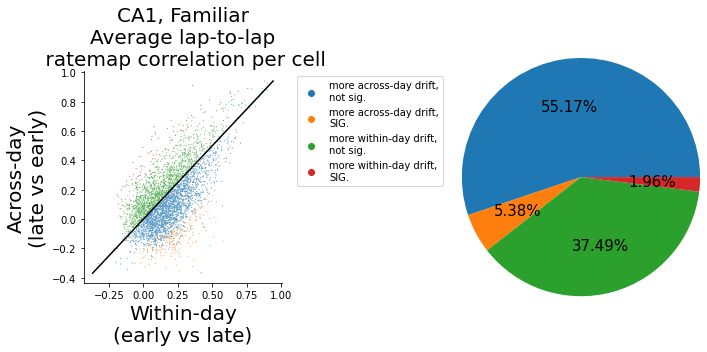

In [204]:
# only subselecting high si, one exp-famnovel
region='CA1'
isnovel=0
dosave=False

per_cell_metrics_oneregionfamnovel_maxday=per_cell_metrics.loc[region,slice(None),slice(None),isnovel].groupby(level=(0,2)).max()
si_thresh=per_cell_metrics_oneregionfamnovel_maxday['si'].quantile(0.8)
fr_thresh=per_cell_metrics_oneregionfamnovel_maxday['mean_fr'].quantile(0.2)
per_cell_metrics_oneregionfamnovel_maxday = per_cell_metrics_oneregionfamnovel_maxday.query('si>@si_thresh&mean_fr>@fr_thresh')
inds = per_cell_metrics_oneregionfamnovel_maxday.index


beg_end_corr_diff_df_sub=beg_end_corr_diff_df_allsess.loc[region,slice(None),isnovel]
mask = beg_end_corr_diff_df_sub.index.to_frame(index=False)[[0, 1]].apply(tuple, axis=1).isin(inds)

toplot = beg_end_corr_diff_df_sub.loc[mask.values]
# plot_scatter_line_and_pie(toplot,x,y,hue,dosave=False,region=region,isnovel=isnovel,isnovel_str=isnovel_str,fig=None,axs=None,save_fn_extra='')
fig,axs=plot_scatter_line_and_pie(toplot,x,y,hue,dosave=dosave,region=region,isnovel=isnovel,fig=None,axs=None,save_fn_extra='_high_si')


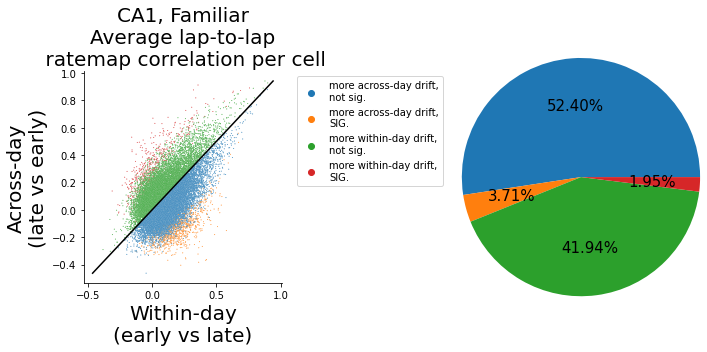

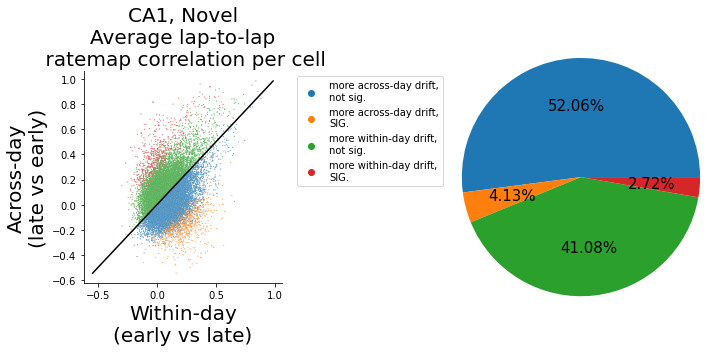

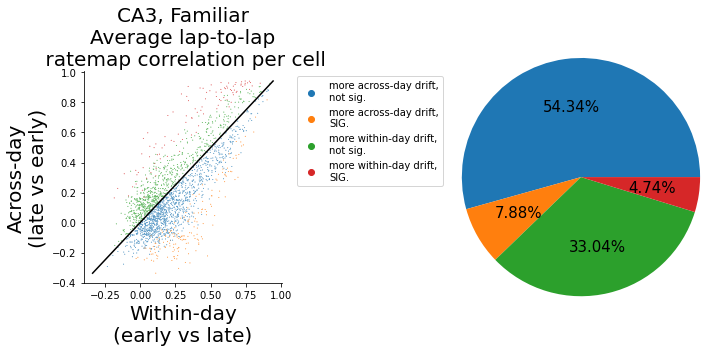

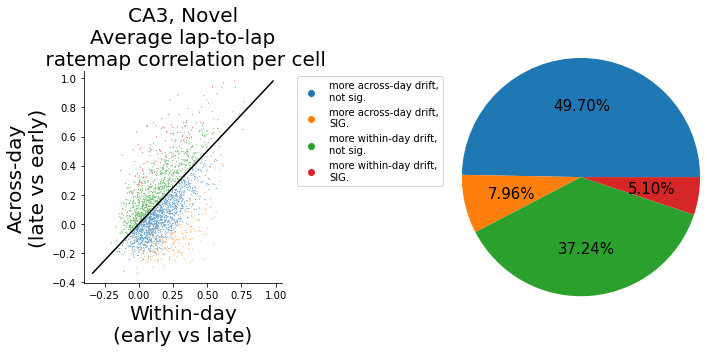

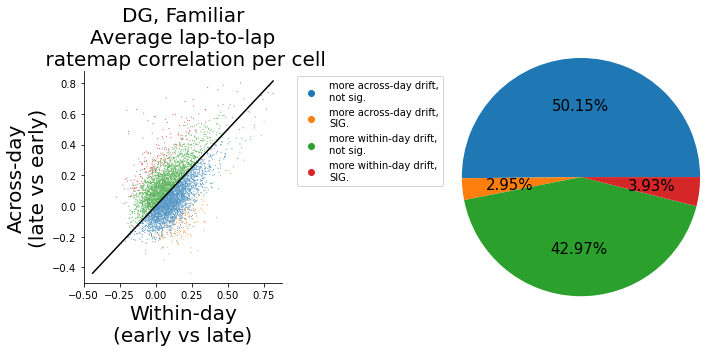

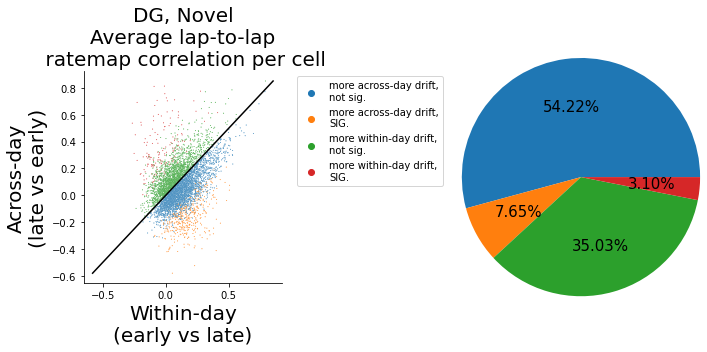

In [149]:
# all exp-famnovel, no subselecting
x='beg_end_same'
y='end_beg_across'
hue='categories'

region='CA1'
isnovel=0
dosave=False
for k,val in beg_end_corr_diff_df_allsess.groupby(level=(0,2)):
    fig,axs=plt.subplots(1,2,figsize=(10,5))
    region,isnovel=k

    isnovel_str = ['Familiar','Novel'][isnovel]
    beg_end_corr_diff_df_sub=beg_end_corr_diff_df_allsess.loc[region,slice(None),isnovel]

    toplot = beg_end_corr_diff_df_sub
    fig,axs=plot_scatter_line_and_pie(toplot,x,y,hue,dosave=dosave,region=region,isnovel=isnovel,fig=None,axs=None,save_fn_extra='')
    

In [205]:
# select some example neurons
region='CA1'
isnovel=0
dosave=False

per_cell_metrics_oneregionfamnovel_maxday=per_cell_metrics.loc[region,slice(None),slice(None),isnovel].groupby(level=(0,2)).max()
si_thresh=per_cell_metrics_oneregionfamnovel_maxday['si'].quantile(0.8)
fr_thresh=per_cell_metrics_oneregionfamnovel_maxday['mean_fr'].quantile(0.2)
per_cell_metrics_oneregionfamnovel_maxday = per_cell_metrics_oneregionfamnovel_maxday.query('si>@si_thresh&mean_fr>@fr_thresh')
inds = per_cell_metrics_oneregionfamnovel_maxday.index


beg_end_corr_diff_df_sub=beg_end_corr_diff_df_allsess.loc[region,slice(None),isnovel]
mask = beg_end_corr_diff_df_sub.index.to_frame(index=False)[[0, 1]].apply(tuple, axis=1).isin(inds)

beg_end_corr_diff_df_sub = beg_end_corr_diff_df_sub.loc[mask.values]



In [303]:
# visualize individual examples

# ma=beg_end_corr_diff_df_sub['issig']&beg_end_corr_diff_df_sub['across_bigger'] &(beg_end_corr_diff_df_sub['end_beg_across'] > 0.3)
ma=beg_end_corr_diff_df_sub['issig']&(~beg_end_corr_diff_df_sub['across_bigger']) &(beg_end_corr_diff_df_sub['beg_end_same'] > 0.3)
ii=12
row=beg_end_corr_diff_df_sub.loc[ma].iloc[ii]
print(row)
exp,uid,_=row.name

X_df=fr_map_trial_df_all_day.loc[region,exp,isnovel,uid]
# fig,ax=ph.heatmap(X_df.T)


end_beg_across        -0.083585
beg_end_same           0.328741
diff                  -0.412326
across_bigger             False
statistic             -2.520288
pvalue                 0.011726
issig                      True
categories        (False, True)
Name: (8, 790, 0), dtype: object


/mnt/home/szheng/projects/place_variability/code/thomas_18_data/get_thomas_cell_metrics.py:259: UserWarning: The figure layout has changed to tight
  # ph.plot_day_on_heatmap(beg_end_corr,vline=True,ax=ax)


end_beg_across        -0.083585
beg_end_same           0.328741
diff                  -0.412326
across_bigger             False
statistic             -2.520288
pvalue                 0.011726
issig                      True
categories        (False, True)
Name: (8, 790, 0), dtype: object


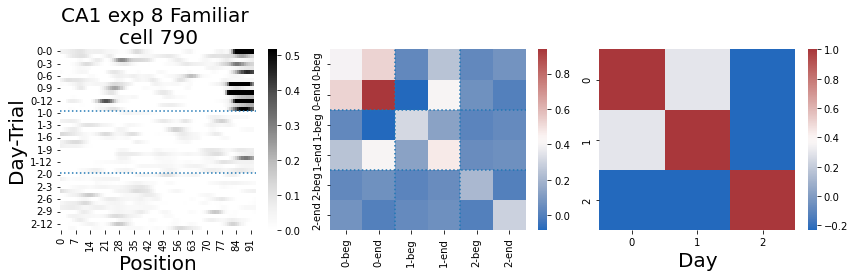

In [304]:
dosave = False
gtcm.end_beg_diff_minus_beg_end_same_show_one_cell(fr_map_trial_df_all_day,frmap_all_day,vmax_quantile=0.99,region=region,exp=exp,isnovel=isnovel,uid=uid,
                                                dosave=dosave,savedir=figdir,savefn_func = lambda x:f'across_within_diff_{x[0]}_exp{x[1]}_isnovel{x[2]}_cell{x[3]}',
                                                day_level = 0,n_tr=3
                                                )
print(row)

In [144]:
region='CA1'
isnovel=0
toplot.loc[region,slice(None),isnovel]

end_beg_across  beg_end_same      diff  across_bigger  statistic  \
0  0   0        0.182551      0.034185  0.148366           True   0.308607   
       1       -0.190053      0.127697 -0.317750          False  -2.160247   
       2        0.138603      0.448684 -0.310081          False  -2.263116   
   1   0       -0.127226      0.080075 -0.207301          False  -2.160247   
       1        0.094618      0.172250 -0.077632          False  -0.771517   
...                  ...           ...       ...            ...        ...   
14 148 3        0.012974     -0.047666  0.060640           True   0.925820   
   149 0       -0.114690      0.337572 -0.452262          False  -3.497543   
       1        0.116685      0.102961  0.013724           True   0.000000   
       2       -0.080013     -0.040839 -0.039174          False   0.257172   
       3        0.074247      0.001381  0.072865           True   0.720082   

            pvalue  issig      categories  
0  0   0  0.757621  False   (True, False)  
       1  0.030754  False  (False, False)  
       2  0.023629  False  (False, False)  
   1   0  0.030754  False  (False, False)  
       1  0.440401  False  (False, False)  
...            ...    ...             ...  
14 148 3  0.354539  False   (True, False)  
   149 0  0.000470   True   (False, True)  
       1  1.000000  False   (True, False)  
       2  0.797046  False  (False, False)  
       3  0.471474  False   (True, False)  

[23779 rows x 8 columns]

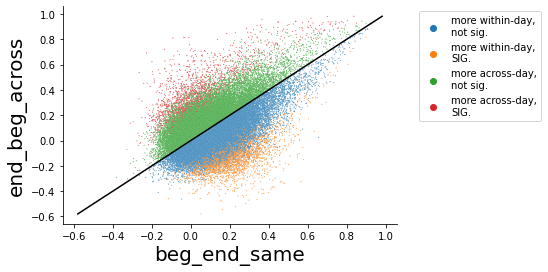

In [112]:
fig

In [21]:
counts=beg_end_corr_diff_df_allsess.groupby(['across_bigger','issig']).count().iloc[:,0]

In [35]:
day_dict={True:'more across-day drift',False:'more within-day drift'}
issig_dict={True:'significant',False:'not significant'}
labels=counts.index.to_frame().apply(lambda x:f'{day_dict[x.iloc[0]]},\n{issig_dict[x.iloc[1]]}',axis=1)

([<matplotlib.patches.Wedge at 0x1550eb4f93d0>,
 [Text(-0.0760772473732458, 1.0973660521594926, 'more within-day drift,\nnot significant'),
  Text(-1.0577910907701076, -0.3017913323596064, 'more within-day drift,\nsignificant'),
  Text(0.13525864842818838, -1.091652462107506, 'more across-day drift,\nnot significant'),
  Text(1.095988480341647, -0.0938576100186213, 'more across-day drift,\nsignificant')])

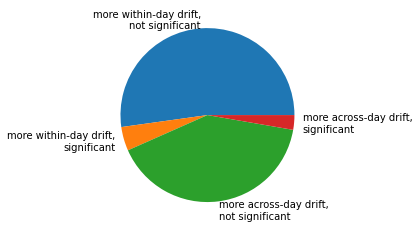

In [36]:
plt.pie(counts,labels=labels)

In [264]:
beg_end_corr_diff_df.groupby(level=0)['across_bigger'].any().mean()

0.8153310104529616

In [265]:
beg_end_corr_diff_df.groupby(level=0)['across_bigger'].all().mean()

0.1254355400696864

In [115]:
def scatter_with_unit_line(toplot,x,y,hue,fig=None,ax=None,**kwargs):
    if ax is None:
        fig,ax=plt.subplots()

    ax=sns.scatterplot(data=toplot,x=x,y=y,hue=hue,ax=ax,**kwargs)
    corr_min=toplot[[x,y]].min().min()
    corr_max=toplot[[x,y]].max().max()
    ax.plot([corr_min,corr_max],[corr_min,corr_max],color='k')
    sns.despine()
    return fig,ax

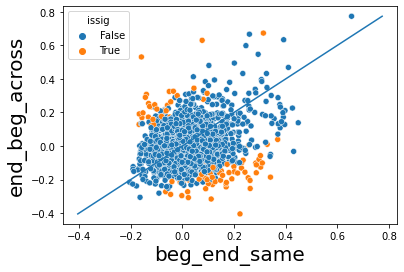

In [10]:
x='beg_end_same'
y='end_beg_across'
toplot = beg_end_corr_diff_df
ax=sns.scatterplot(data=toplot,x=x,y=y,hue=hue)
corr_min=toplot[[x,y]].min().min()
corr_max=toplot[[x,y]].max().max()
ax.plot([corr_min,corr_max],[corr_min,corr_max])


In [11]:
beg_end_corr_diff_df.query('across_bigger&issig')

end_beg_across  beg_end_same      diff  across_bigger  statistic  \
6   2        0.308205     -0.138973  0.447178           True   3.394674   
36  2        0.128770     -0.167463  0.296234           True   3.240370   
41  2        0.169534     -0.156352  0.325885           True   3.291805   
49  0        0.191240     -0.166877  0.358117           True   2.880329   
    1        0.530918     -0.158354  0.689272           True   4.114756   
90  0        0.208659     -0.068044  0.276703           True   2.931764   
110 0        0.673241      0.313825  0.359415           True   2.674591   
132 2        0.278667      0.081045  0.197622           True   2.417419   
136 0        0.172610     -0.131257  0.303867           True   2.828895   
138 2        0.212753     -0.069896  0.282648           True   2.674591   
145 2        0.290165     -0.143090  0.433255           True   3.446108   
157 0        0.630050      0.076770  0.553280           True   2.674591   
168 2        0.121667     -0.119545  0.241211           True   2.674591   
175 2        0.197612     -0.152283  0.349894           True   2.880329   
180 1        0.233490     -0.119027  0.352518           True   2.828895   
192 2        0.300707     -0.019777  0.320484           True   2.468854   
193 2        0.243401     -0.057497  0.300897           True   2.880329   
274 2        0.314149      0.095994  0.218155           True   2.417419   
280 2        0.173053     -0.048803  0.221856           True   2.520288   
283 1        0.126760     -0.110910  0.237670           True   2.417419   
331 2        0.158721     -0.113695  0.272416           True   2.571722   
348 1        0.325023     -0.050592  0.375615           True   2.983198   
356 1        0.253720     -0.130654  0.384374           True   3.548977   
357 0        0.263775     -0.044775  0.308550           True   2.674591   
374 0        0.135077     -0.155006  0.290083           True   2.623157   
394 0        0.176720     -0.080456  0.257176           True   2.468854   
402 2        0.210304     -0.062575  0.272879           True   2.417419   
410 2        0.326851     -0.034686  0.361537           True   2.983198   
463 0        0.235996     -0.126358  0.362354           True   2.623157   
495 0        0.246167     -0.106712  0.352879           True   2.777460   
547 2        0.344847      0.045029  0.299817           True   2.931764   
558 0        0.220274     -0.098719  0.318993           True   3.188936   

         pvalue  issig  
6   2  0.000687   True  
36  2  0.001194   True  
41  2  0.000995   True  
49  0  0.003973   True  
    1  0.000039   True  
90  0  0.003370   True  
110 0  0.007482   True  
132 2  0.015631   True  
136 0  0.004671   True  
138 2  0.007482   True  
145 2  0.000569   True  
157 0  0.007482   True  
168 2  0.007482   True  
175 2  0.003973   True  
180 1  0.004671   True  
192 2  0.013555   True  
193 2  0.003973   True  
274 2  0.015631   True  
280 2  0.011726   True  
283 1  0.015631   True  
331 2  0.010119   True  
348 1  0.002853   True  
356 1  0.000387   True  
357 0  0.007482   True  
374 0  0.008712   True  
394 0  0.013555   True  
402 2  0.015631   True  
410 2  0.002853   True  
463 0  0.008712   True  
495 0  0.005479   True  
547 2  0.003370   True  
558 0  0.001428   True

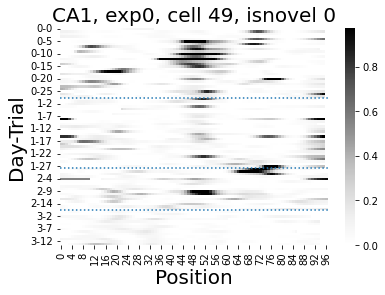

In [287]:
uid=49
X_df_ = fr_map_trial_df_all_day.loc[(region,exp,isnovel,uid),:].dropna(axis=1,how='all')
fig,ax=ph.heatmap(X_df_.T)
ph.plot_day_on_heatmap(X_df_.T,ax=ax)
_=ax.set(ylabel='Day-Trial',title=f'{region}, exp{exp}, cell {uid}, isnovel {isnovel}',xlabel='Position')


In [275]:
# beg_end_corr_diff_df['issig']=beg_end_corr_diff_df['pvalue'] < 0.05
counts=beg_end_corr_diff_df.groupby(['across_bigger','issig']).count().iloc[:,0]

In [278]:
counts=counts.unstack()

In [281]:
counts

issig,False,True
across_bigger,,
False,809,58
True,749,32


In [280]:
scipy.stats.chi2_contingency(counts)

Chi2ContingencyResult(statistic=4.858128468933846, pvalue=0.027516169213886374, dof=1, expected_freq=array([[819.65169903,  47.34830097],
       [738.34830097,  42.65169903]]))

In [92]:
end_i=X_df_.loc[:,(i,slice(None))].iloc[:,tr_l['end']]
beg_i_plus_1=X_df_.loc[:,(i+1,slice(None))].iloc[:,tr_l['beg']]

In [103]:
pd.concat([end_i.stack().reset_index(drop=True),beg_i_plus_1.stack().reset_index(drop=True)],axis=1).corr()

,2,3
2,1.000000,0.143416
3,0.143416,1.000000


In [110]:
end_beg

array([ 0.47324411,  0.42726518, -0.19611011, -0.33717168, -0.33651428,
       -0.02250498, -0.13493142, -0.00229129, -0.1673431 ])

In [109]:
np.median(end_beg)

-0.13493142133347813

In [249]:
reload(gtcm)
diff_l = gtcm.test_end_beg_diff_minus_beg_end_same_direct_noshuffle(sim)

In [250]:
diff_l

,statistic,pvalue
0,2.314550,0.020638
1,0.565779,0.571544
2,-0.874386,0.381908


In [56]:
uid=9
day_level = 0
n_tr=3
X_df_ = fr_map_trial_df_all_day.loc[(region,exp,isnovel,uid),:].dropna(axis=1,how='all')
sim = X_df_.corr()
day_l = sim.columns.get_level_values(day_level).unique()
tr_l ={'beg':slice(0,n_tr),'end':slice(-n_tr,None)}
diff_l = []
end_beg_l = []
beg_end_mean_l = []
for i in range(len(day_l)-1):
    end_beg = sim.loc[(i,slice(None)),(i+1,slice(None))].iloc[tr_l['end'],tr_l['beg']].values.flatten()
    beg_end_i = sim.loc[(i,slice(None)),(i,slice(None))].iloc[tr_l['end'],tr_l['beg']].values.flatten()
    beg_end_i_plus_1 = sim.loc[(i+1,slice(None)),(i+1,slice(None))].iloc[tr_l['end'],tr_l['beg']].values.flatten()
#     beg_end_mean = (beg_end_i + beg_end_i_plus_1) / 2
    beg_end_same=np.concatenate([beg_end_i,beg_end_i_plus_1])
#     diff=scipy.stats.ttest_ind(end_beg,beg_end_same)
    diff=scipy.stats.ranksums(end_beg,beg_end_same)
    
#     diff = end_beg - beg_end_mean
#     end_beg_l.append(end_beg)
#     beg_end_mean_l.append(beg_end_mean)
    diff_l.append(diff)
# diff_l = np.array(diff_l)
# end_beg_l = np.array(end_beg_l)
# beg_end_mean_l = np.array(beg_end_mean_l)

In [248]:
pd.DataFrame(diff_l)

,statistic,pvalue
0,2.314550,0.020638
1,0.565779,0.571544
2,-0.874386,0.381908


[RanksumsResult(statistic=2.3145502494313788, pvalue=0.020637558243972183),
 RanksumsResult(statistic=0.5657789498610036, pvalue=0.571544057890823),
 RanksumsResult(statistic=-0.8743856497851875, pvalue=0.38190826963907143)]

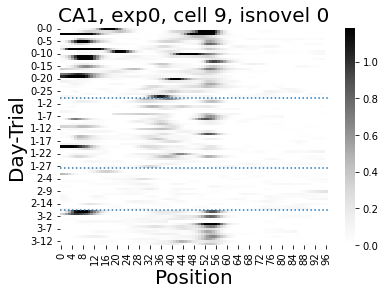

In [57]:
fig,ax=ph.heatmap(X_df_.T)
ph.plot_day_on_heatmap(X_df_.T,ax=ax)
_=ax.set(ylabel='Day-Trial',title=f'{region}, exp{exp}, cell {uid}, isnovel {isnovel}',xlabel='Position')
diff_l

In [70]:
sim_val = sim.values
sim_val = sim_val[np.triu_indices_from(sim_val,k=1)]

sample: 100%|██████████| 3000/3000 [00:04<00:00, 745.95it/s, 3 steps of size 3.81e-01. acc. prob=0.93]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      3.74      0.08      3.74      3.60      3.87    700.69      1.00
      beta      2.68      0.06      2.68      2.59      2.78    661.05      1.00

Number of divergences: 0


In [231]:
Y.shape

(3, 97)

sample: 100%|██████████| 1500/1500 [00:29<00:00, 50.66it/s, 3 steps of size 6.14e-01. acc. prob=0.95]


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length      6.08      1.80      5.67      3.96      8.02    243.92      1.01
   kernel_noise      0.00      0.00      0.00      0.00      0.00    527.15      1.00
     kernel_var      0.00      0.00      0.00      0.00      0.00    357.08      1.00

Number of divergences: 0

MCMC elapsed time: 30.465736150741577


In [63]:
scipy.stats.ttest_ind(end_beg,beg_end_same)

Ttest_indResult(statistic=-1.1055019926221867, pvalue=0.2794678914663327)

(array([1., 1., 3., 0., 1., 1., 0., 0., 1., 1.]),
 array([-0.41891836, -0.32656885, -0.23421934, -0.14186983, -0.04952032,
         0.04282918,  0.13517869,  0.2275282 ,  0.31987771,  0.41222722,
         0.50457673]),
 <BarContainer object of 10 artists>)

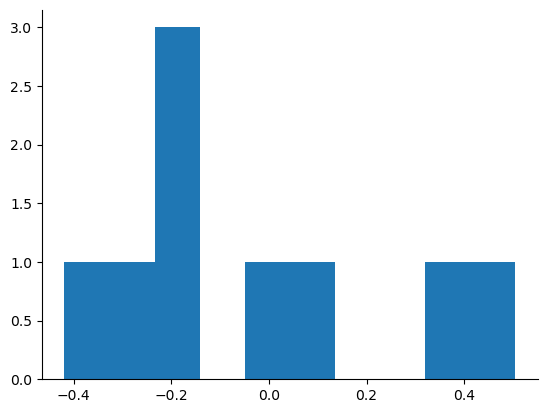

In [20]:
plt.hist(sim.loc[(i,slice(None)),(i,slice(None))].iloc[tr_l['end'],tr_l['beg']].values.flatten())

(array([ 19., 204., 797., 763., 507., 428., 326., 284., 278., 135.]),
 array([-0.59539913, -0.43723073, -0.27906233, -0.12089393,  0.03727447,
         0.19544287,  0.35361127,  0.51177967,  0.66994807,  0.82811647,
         0.98628488]),
 <BarContainer object of 10 artists>)

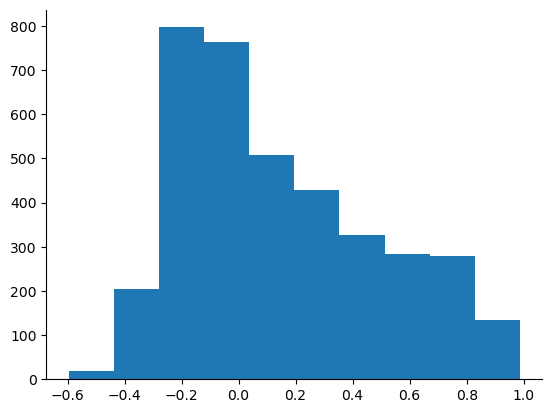

In [17]:
%matplotlib inline
xx=sim.values[np.triu_indices_from(sim.values,1)]
plt.hist(xx)

In [110]:
db = database.thomas_18_db
db_grouped = db.groupby(['region','exp_ind']).mean().index # group on the level of region and exp

In [106]:
ff=1/2*np.log((1+xx)/(1-xx))

In [16]:
sim.loc[(i,slice(None)),(i+1,slice(None))].iloc[tr_l['end'],tr_l['beg']]

3                    
             0         1         2
2 14  0.050529  0.238840  0.054456
  15  0.444298  0.010854  0.163156
  16  0.043873  0.065667  0.175755

In [11]:
beg_end_corr_diff_df

end_beg_across  beg_end_same      diff  across_bigger
0   0        0.182551      0.034185  0.148366           True
    1       -0.190053      0.127697 -0.317750          False
    2        0.138603      0.448684 -0.310081          False
1   0       -0.127226      0.080075 -0.207301          False
    1        0.094618      0.172250 -0.077632          False
...               ...           ...       ...            ...
572 1        0.024602      0.029970 -0.005368          False
    2       -0.100979      0.309573 -0.410552          False
573 0        0.100170     -0.057485  0.157655           True
    1       -0.153815     -0.033633 -0.120182          False
    2       -0.067871      0.102627 -0.170498          False

[1722 rows x 4 columns]

# distraction, dim reduction

In [ ]:
from sklearn.manifold import MDS,Isomap

xx=X_df_.dropna(axis=0,how='all').dropna(axis=1,how='all').fillna(0)
# model=MDS(n_components=3,dissimilarity='precomputed')
model=Isomap(n_components=3)
# res=mds.fit_transform(1-sim)
res=model.fit_transform(xx.T)
res = pd.DataFrame(res)
res['day'] = sim.columns.get_level_values(0)
res['trial_within'] = sim.columns.get_level_values(1)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

def plot_3d_scatter(df):
    """
    Create a 3D scatter plot with different markers for each 'day' and 
    different colors for each 'trial_within' value, connecting points
    within the same day.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing the data to plot.
    """
    # Ensure 'day' and 'trial_within' are categorical
    df['day'] = df['day'].astype('category')
    df['trial_within'] = df['trial_within'].astype('category')
    
    # Define some markers
    markers = ['o', 's', '^', 'v', '<', '>', 'D', 'H', '8', 'p']
    
    # Ensure there are not more unique days than markers
    if len(df['day'].cat.categories) > len(markers):
        raise ValueError("Too many unique days for available markers. Add more markers or reduce days.")
    
    # Create a colormap based on the unique values of 'trial_within'
    cmap = plt.cm.get_cmap('Spectral_r')
    norm = plt.Normalize(vmin=df['trial_within'].cat.codes.min(), vmax=df['trial_within'].cat.codes.max())
    
    # Create a 3D subplot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Create a legend proxy (for days)
    legend_elements = []
    
    # Loop through each unique day
    for i, day in enumerate(df['day'].cat.categories):
        # Filter the data for the current day
        day_data = df[df['day'] == day].sort_values(by='trial_within')
        
        # Plot lines connecting points within the same day
        ax.plot(day_data[0], day_data[1], day_data[2], 
                marker=None, linestyle='-', color='gray', alpha=0.5)
        
        # Loop through each unique trial_within
        for j, trial in enumerate(df['trial_within'].cat.categories):
            # Filter the data for the current trial_within
            trial_data = day_data[day_data['trial_within'] == trial]
            
            # Plot the data with the specified marker and color
            sc = ax.scatter(trial_data[0], trial_data[1], trial_data[2], 
                            marker=markers[i], 
                            color=cmap(norm(trial_data['trial_within'].cat.codes.values)),
                            label=f"Day: {day}, Trial: {trial}" if i == 0 else "")
        
        # Add legend element for the day
        legend_elements.append(plt.Line2D([0], [0], marker=markers[i], color='w', 
                                          markerfacecolor='k', markersize=10, 
                                          label=f'Day: {day}'))
    
    # Add labels and legend
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend(handles=legend_elements, loc='upper left')
    
    # Add colorbar
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array(df['trial_within'].cat.codes)
    cbar = plt.colorbar(mappable, ax=ax)
    cbar.set_label('Trial Within')
    cbar.set_ticks(np.arange(len(df['trial_within'].cat.categories)))
    cbar.set_ticklabels(df['trial_within'].cat.categories)
    
    # Show the plot
    plt.show()

# Example usage:
# Assuming df is your DataFrame with columns: 0, 1, 2, 'day', 'trial_within'
# plot_3d_scatter(df)


%matplotlib notebook
plot_3d_scatter(res)